In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import string
import random
from tqdm.auto import tqdm
import torch
import transformers
from transformers import GPTNeoForCausalLM, GPT2Tokenizer
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from transformers import AdamW, get_cosine_schedule_with_warmup
from transformers import pipeline, set_seed

In [ ]:
set_seed(42)

In [ ]:
data = pd.read_csv("/kaggle/input/summary-final-context/Summary_Final_context.csv")

In [ ]:
data.head(3)

,Pros,Cons,base msrp,Full Name,GPT-2 Summarization,horsepower,engine_type,Torque,Torque_RPM,drive_type,transmission,width,Length,Height,Context,final_context
0,"['Unmatched off-road capability, overflowing w...","['Soft top is fun, but still a pain in the $%!...",not available,jeep wrangler 1998,Jeep has improved off-road capability by incre...,120,Inline 4,140 lb-ft,"3,500",four wheel drive,5-speedmanual,66.7,147.7 in.,69.6 in.,The jeep wrangler 1998 is a vehicle with a Inl...,The jeep wrangler 1998 is a vehicle with a Inl...
1,"['Powerful engine lineup, well mannered on pav...","[""Cargo capacity isn't much more than what man...","$27,795",toyota 4runner 2005,The base V6 now comes with a five-speed automa...,245,V6,282 lb-ft,"3,800",rear wheel drive,5-speedautomatic,73.8,189.0 in.,68.5 in.,The toyota 4runner 2005 is a vehicle with a V6...,The toyota 4runner 2005 is a vehicle with a V6...
2,"['Silky V8, Toyota build quality, less-than-fu...",['Lacks wide range of choice offered by domest...,"$15,605",toyota tundra 2002,"SR5 models have new 16-inch wheels, and a limi...",190,V6,220 lb-ft,"3,600",rear wheel drive,5-speedmanual,75.2,217.5 in.,70.5 in.,The toyota tundra 2002 is a vehicle with a V6 ...,The toyota tundra 2002 is a vehicle with a V6 ...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141 entries, 0 to 3140
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Pros                 3141 non-null   object 
 1   Cons                 3141 non-null   object 
 2   base msrp            3141 non-null   object 
 3   Full Name            3141 non-null   object 
 4   GPT-2 Summarization  3141 non-null   object 
 5   horsepower           3141 non-null   int64  
 6   engine_type          3141 non-null   object 
 7   Torque               3141 non-null   object 
 8   Torque_RPM           3141 non-null   object 
 9   drive_type           3141 non-null   object 
 10  transmission         3141 non-null   object 
 11  width                3094 non-null   float64
 12  Length               3141 non-null   object 
 13  Height               3141 non-null   object 
 14  Context              3141 non-null   object 
 15  final_context        3141 non-null   o

In [ ]:
data= data.drop(columns=['Pros','Cons','horsepower','engine_type','Torque','Torque_RPM','drive_type','transmission','width','Length','Height'])

In [ ]:
prompts = []
targets = []
li = []
for index, row in data.iterrows():
    #remove \n and replace with space
    carName = str(row['Full Name']).replace('\n', ' ')
    #engine = str(row['engine']).replace('\n', ' ')
    #drivetrain = str(row['drivetrain']).replace('\n', ' ')
    #dimensions = str(row['dimensions']).replace('\n', ' ')
    description = str(row['final_context']).replace('\n', ' ')
    #prompt = 'Car: ' + carName + " "+ str(row['year']) + '\nEngine: ' + engine + '\nDrivetrain: ' + drivetrain + '\nDimensions: ' + dimensions + '\nDescription: '
    prompt = 'Car: ' + carName+'\nDescription: '
    target = description
    targets.append(target)
    prompts.append(prompt)
    li.append(prompt + ' ' + target)
    
data['prompt_target'] = li

In [ ]:
data['prompt_target']

0       Car: jeep wrangler 1998\nDescription:  The jee...
1       Car: toyota 4runner 2005\nDescription:  The to...
2       Car: toyota tundra 2002\nDescription:  The toy...
3       Car: toyota tacoma 1998\nDescription:  The toy...
4       Car: ford ranger 1990\nDescription:  The ford ...
                              ...                        
3136    Car: jeep renegade 2023\nDescription:  The jee...
3137    Car: bmw alpina-b7 2022\nDescription:  The bmw...
3138    Car: chevrolet colorado 2022\nDescription:  Th...
3139    Car: bmw 4-series 2023\nDescription:  The bmw ...
3140    Car: ford f-250-super-duty 2022\nDescription: ...
Name: prompt_target, Length: 3141, dtype: object

In [ ]:
print(li[0])

Car: jeep wrangler 1998
Description:  The jeep wrangler 1998 is a vehicle with a Inline 4 engine that delivers 120 horsepower and 140 lb-ft torque at 3,500. It has four wheel drive  and a 5-speedmanual. The car's dimensions are 147.7 in. in length, 69.6 in. in height, and 66.7 in width . Additionally, the base MSRP of this car is not available.  Now an in depth review of the jeep wrangler 1998:  Jeep has improved off-road capability by increasing the axle ratio offered with the 4.0-liter engine and revising the torsion bar for better steering. Optional this year on the 1998 Jeep Wrangler are a tilting driver seat, automatic speed control, a combination CD/cassette stereo, a new Smart Key Immobilizer theft-deterrent system and two new colors. We were a little concerned last year when we heard that Jeep was giving its bad-boy mud-machine  an overhaul. Luckily, the Wrangler hasn't received the leather interior, cellular phone makeover that has recently emasculated so much of the sport-uti

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

tokenized_data = data['prompt_target'].apply((lambda x: tokenizer.encode(x, max_length=1024,truncation=True)))

In [ ]:
# Define padding function
def pad_sequence(seq, max_len):
    seq_len = len(seq)
    if seq_len < max_len:
        seq = seq + [0] * (max_len - seq_len)
    elif seq_len > max_len:
        seq = seq[:max_len]
    return seq


In [ ]:
# Pad sequences
max_len = 1024
padded_data = [pad_sequence(seq, max_len) for seq in tokenized_data.values]
# Convert integers to strings and pad with spaces
padded_strings = [[' ' + chr(i) for i in seq] for seq in padded_data]
padded_strings = [[s[1:] for s in seq] for seq in padded_strings]
padded_strings = [pad_sequence(seq, max_len) for seq in padded_strings]
# Vectorize padded data
vectorized_data = np.vectorize(lambda x: ord(x))(padded_strings)

In [ ]:
# Flatten padded_data
padded_data = np.array([np.ravel(x) for x in padded_data]).astype(np.int64)

# Create attention masks
attention_masks = np.where(padded_data != 0, 1, 0)

In [ ]:
!conda install -y gdown

Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - rapidsai/linux-64::libcuml==21.12.00=cuda11_g04c4927f3_0
  - conda-forge/linux-64::abseil-cpp==20211102.0=h93e1e8c_3
  - rapidsai/linux-64::dask-cudf==21.12.02=cuda_11_py37_g06540b9b37_0
  - conda-forge/linux-64::pyarrow==5.0.0=py37h8cf84b7_35_cuda
  - rapidsai/linux-64::cuml==21.12.00=cuda11_py37_g04c4927f3_0
  - conda-forge/linux-64::grpc-cpp==1.45.2=he70e3f0_3
  - rapidsai/linux-64::libcudf==21.12.02=cuda11_g06540b9b37_0
  - conda-forge/linux-64::arrow-cpp==5.0.0=py37h846d386_35_cuda
  - rapidsai/linux-64::cudf==21.12.02=cuda_11_py37_g06540b9b37_0
  - conda-forge/noarch::parquet-cpp==1.5.1=2
  - conda-forge/linux-64::libabseil==20211102.0=cxx17_h48a1fff_3
done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base -c conda-

In [ ]:
#https://drive.google.com/file/d/16fTX3RS3mF2ayn9YYWoNJBrfg6Cr8kpk/view?usp=share_link
#https://drive.google.com/file/d/<----16fTX3RS3mF2ayn9YYWoNJBrfg6Cr8kpk---->/view?usp=share_link

In [ ]:
!gdown --id 17qBwI-JRxLARe2krOQLVj_87_xvwAEuu #16fTX3RS3mF2ayn9YYWoNJBrfg6Cr8kpk 

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:130: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From (uriginal): https://drive.google.com/uc?id=17qBwI-JRxLARe2krOQLVj_87_xvwAEuu
From (redirected): https://drive.google.com/uc?id=17qBwI-JRxLARe2krOQLVj_87_xvwAEuu&confirm=t&uuid=2d3d15ad-f473-4ec7-9531-5568fd64d305
To: /kaggle/working/PreFineTune_Drive_type.zip
100%|████████████████████████████████████████| 463M/463M [00:07<00:00, 61.2MB/s]


In [ ]:
! unzip "/kaggle/working/PreFineTune_Drive_type.zip" -d PreFineTune_Drive_type

Archive:  /kaggle/working/PreFineTune_Drive_type.zip
  inflating: PreFineTune_Drive_type/pytorch_model.bin  
  inflating: PreFineTune_Drive_type/config.json  


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GPT2LMHeadModel.from_pretrained('/kaggle/working/PreFineTune_Drive_type')
model.eval()
model.to(device)


Some weights of the model checkpoint at /kaggle/working/PreFineTune_Drive_type were not used when initializing GPT2LMHeadModel: ['score.weight']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

In [ ]:
from sklearn.model_selection import train_test_split

train_data, val_data, train_masks, val_masks = train_test_split(padded_data, attention_masks, test_size=0.1)

In [ ]:

train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_data), torch.tensor(train_masks))
val_dataset = torch.utils.data.TensorDataset(torch.tensor(val_data), torch.tensor(val_masks))

batch_size = 2
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

optimizer = AdamW(model.parameters(), lr=1e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*10)


In [ ]:
train_losses = []
val_losses = []

In [ ]:
epochs = 5

for epoch in tqdm(range(1, epochs+1)):
    model.train()
    total_loss = 0
    for batch in tqdm(train_dataloader):
        inputs, masks = (i.to(device) for i in batch)
        model.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=inputs)
        loss = outputs[0]
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
        scheduler.step()
    
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))
    train_losses.append(avg_train_loss)
    
  # Evaluate the model on the validation set
    model.eval()
    total_eval_loss = 0
    progress_bar = tqdm(val_dataloader, desc=f"Epoch {epoch}", leave=False)
    for batch in progress_bar:
        inputs, masks = (i.to(device) for i in batch)
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=inputs)
            loss = outputs[0]
            total_eval_loss += loss.item()
        progress_bar.set_postfix({'validation_loss': '{:.3f}'.format(loss.item())})
    
    avg_eval_loss = total_eval_loss / len(val_dataloader)
    val_losses.append(avg_eval_loss)
    print("Average validation loss: {}".format(avg_eval_loss))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1413 [00:00<?, ?it/s]

Average train loss: 1.49732259384133


Epoch 1:   0%|          | 0/158 [00:00<?, ?it/s]

Average validation loss: 1.2043169725544844


  0%|          | 0/1413 [00:00<?, ?it/s]

Average train loss: 1.204570981780013


Epoch 2:   0%|          | 0/158 [00:00<?, ?it/s]

Average validation loss: 1.137982593778568


  0%|          | 0/1413 [00:00<?, ?it/s]

Average train loss: 1.1430045255029446


Epoch 3:   0%|          | 0/158 [00:00<?, ?it/s]

Average validation loss: 1.0997794996711272


  0%|          | 0/1413 [00:00<?, ?it/s]

Average train loss: 1.1029828996921547


Epoch 4:   0%|          | 0/158 [00:00<?, ?it/s]

Average validation loss: 1.0750066107021103


  0%|          | 0/1413 [00:00<?, ?it/s]

Average train loss: 1.0734089037373145


Epoch 5:   0%|          | 0/158 [00:00<?, ?it/s]

Average validation loss: 1.0538008040453815


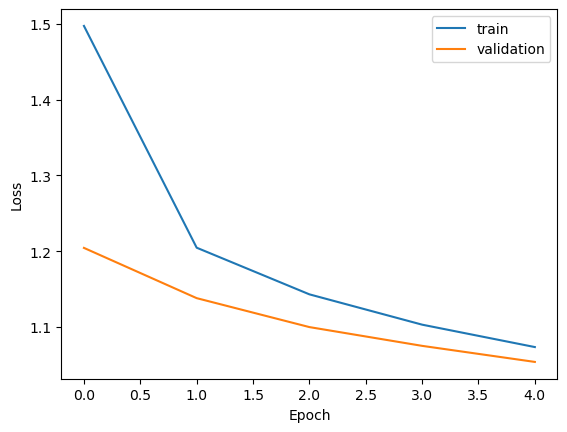

In [ ]:
# Plot the train and validation losses
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
model.save_pretrained('FineTune_gpt2_drive_type')

In [ ]:
import shutil
shutil.make_archive("FineTune_gpt2_drive_type", 'zip', "/kaggle/working/FineTune_gpt2_drive_type")

'/kaggle/working/FineTune_gpt2_drive_type.zip'

In [ ]:
%cd /kaggle/working

/kaggle/working


In [ ]:
from IPython.display import FileLink
FileLink(r'FineTune_gpt2_drive_type.zip')

/kaggle/working/FineTune_gpt2_drive_type.zip

In [ ]:
# Generate text
prompt = """
Car: jeep wrangler 1998
Description:"""

generated_text = tokenizer.encode(prompt, add_special_tokens=False, return_tensors="pt").to(device)
output_text = model.generate(
    generated_text,
    max_length=200,
    temperature=0.9,
    do_sample=False,
    top_k=50,
    top_p=0.95,
    repetition_penalty=1.5,
    num_return_sequences=1,
)

# Decode the generated text
decoded_output = tokenizer.decode(output_text[0], skip_special_tokens=True)

print(decoded_output)

In [ ]:
# Generate text
prompt = """
Car: Honda Accord
description:"""

generated_text = tokenizer.encode(prompt, add_special_tokens=False, return_tensors="pt").to(device)
output_text = model_gpt2_car.generate(
    generated_text,
    max_length=200,
    temperature=0.9,
    do_sample=False,
    top_k=100,
    top_p=0.95,
    repetition_penalty=1.2,
    num_return_sequences=1,
)

# Decode the generated text
decoded_output = tokenizer.decode(output_text[0], skip_special_tokens=True)

print(decoded_output)

In [ ]:
# Generate text
prompt = """
bmw 4-series 2023"""

generated_text = tokenizer.encode(prompt, add_special_tokens=False, return_tensors="pt").to(device)
output_text = model.generate(
    generated_text,
    max_length=200,
    temperature=0.9,
    do_sample=False,
    top_k=50,
    top_p=0.95,
    repetition_penalty=1.5,
    num_return_sequences=1,
)

# Decode the generated text
decoded_output = tokenizer.decode(output_text[0], skip_special_tokens=True)

print(decoded_output)

In [ ]:
model_gpt2_car=model

In [ ]:
model_loaded = GPT2LMHeadModel.from_pretrained('gpt2')
model_loaded.to(device)
#model_loaded.load_state_dict(torch.load('/kaggle/working/gpt-2_car.pt'))

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

In [ ]:
# Generate text
prompt = """
Car: Jeep Wrangler 1998
description:"""

generated_text = tokenizer.encode(prompt, add_special_tokens=False, return_tensors="pt").to(device)
output_text = model_loaded.generate(
    generated_text,
    max_length=200,
    temperature=0.9,
    do_sample=True,
    top_k=100,
    top_p=0.95,
    repetition_penalty=1.2,
    num_return_sequences=1,
)

# Decode the generated text
decoded_output = tokenizer.decode(output_text[0], skip_special_tokens=True)

print(decoded_output)

In [ ]:
import pandas as pd

# Select 10% of the rows randomly
subset_data = data.sample(frac=0.1, random_state=42)

In [ ]:
subset_data

,base msrp,Full Name,GPT-2 Summarization,Context,final_context,prompt_target
2894,"$20,395",honda cr-v 2006,There are no significant changes to the 2006 H...,The honda cr-v 2006 is a vehicle with a Inline...,The honda cr-v 2006 is a vehicle with a Inline...,Car: honda cr-v 2006\nDescription: The honda ...
2969,"$38,835",honda odyssey 2023,"Odds are, if you're thinking about buying a m...",The honda odyssey 2023 is a vehicle with a V6 ...,The honda odyssey 2023 is a vehicle with a V6 ...,Car: honda odyssey 2023\nDescription: The hon...
1064,"$25,400",toyota tacoma 2018,If excellent utility and off-road ability are...,The toyota tacoma 2018 is a vehicle with a Inl...,The toyota tacoma 2018 is a vehicle with a Inl...,Car: toyota tacoma 2018\nDescription: The toy...
1231,"$28,375",honda odyssey 2012,The 2012 Honda Odyssey expands feature content...,The honda odyssey 2012 is a vehicle with a V6 ...,The honda odyssey 2012 is a vehicle with a V6 ...,Car: honda odyssey 2012\nDescription: The hon...
2988,"$59,995",audi rs-3 2023,From a quick glance at the compact 2023 Audi ...,The audi rs-3 2023 is a vehicle with a Inline ...,The audi rs-3 2023 is a vehicle with a Inline ...,Car: audi rs-3 2023\nDescription: The audi rs...
...,...,...,...,...,...,...
25,not available,honda cr-v 2000,The 2000 Honda CR-V gets a new SE (Special Edi...,The honda cr-v 2000 is a vehicle with a Inline...,The honda cr-v 2000 is a vehicle with a Inline...,Car: honda cr-v 2000\nDescription: The honda ...
2633,"$51,630",ford f-450-super-duty 2018,The 2018 Ford F-450 Super Duty receives minor ...,The ford f-450-super-duty 2018 is a vehicle wi...,The ford f-450-super-duty 2018 is a vehicle wi...,Car: ford f-450-super-duty 2018\nDescription: ...
1011,"$14,065",hyundai elantra 2006,A Limited sedan with leather seats and wood gr...,The hyundai elantra 2006 is a vehicle with a I...,The hyundai elantra 2006 is a vehicle with a I...,Car: hyundai elantra 2006\nDescription: The h...
1940,"$22,045",jeep wrangler 2011,The Jeep Wrangler receives a new interior for ...,The jeep wrangler 2011 is a vehicle with a V6 ...,The jeep wrangler 2011 is a vehicle with a V6 ...,Car: jeep wrangler 2011\nDescription: The jee...


In [ ]:
import logging

# Set the logging level to ERROR for the transformers library
logging.getLogger("transformers").setLevel(logging.ERROR)

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm

# Initialize a list to store the BLEU scores
bleu_scores = []

# Loop over each row in the subset using tqdm for progress tracking
for index, row in tqdm(subset_data.iterrows(), total=len(subset_data)):
    # Get the reference text from the 'prompt_target' column
    reference_text = row['prompt_target']
    
    # Generate the text using the GPT-2 model
    prompt = f"Car: {row['Full Name']}\ndescription:"
    generated_text = tokenizer.encode(prompt, add_special_tokens=False, return_tensors="pt").to(device)
    output_text = model_loaded.generate(
        generated_text,
        max_length=450,
        temperature=0.9,
        do_sample=False,
        top_k=100,
        top_p=0.95,
        repetition_penalty=1.2,
        num_return_sequences=1,
    )
    decoded_output = tokenizer.decode(output_text[0], skip_special_tokens=True)
    
    # Calculate the BLEU score
    score = sentence_bleu([reference_text], decoded_output)
    
    # Add the score to the list
    bleu_scores.append(score)

# Calculate the average BLEU score
avg_bleu_score = sum(bleu_scores) / len(bleu_scores)

# Print the average BLEU score
print(f"Average BLEU score: {avg_bleu_score}")

In [ ]:
# Calculate the average BLEU score
avg_bleu_score = sum(bleu_scores) / len(bleu_scores)

# Print the average BLEU score
print(f"Average BLEU score: {avg_bleu_score}")

Average BLEU score: 0.06933455940731181
